# Evaluation Code for Results Analysis

Import required packages

In [ ]:
import sys
import os

print(os.getcwd())
notebook_dir = os.path.abspath("") # get the directory of the current notebook
sys.path.append('..')
from utils import *
import argparse
import json
import pickle
import os
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from pandas.plotting import table
import spacy
nlp = spacy.load("en_core_web_lg")

Set up pint for unit conversion and add custom units

In [2]:
from pint import UnitRegistry
ureg = UnitRegistry()
ureg.define("ton = 1e3 * kg = tonne")
ureg.define("USD = [currency]")
ureg.define("exabyte = 1e9 * GB = eb")
ureg.define("yottabyte = 1e15 * GB = yb")
ureg.define("zetabyte = 1e12 * GB = zb")
ureg.define("terabyte = 1e3 * GB = tb")
ureg.define("petabyte = 1e6 * GB = pb")
ureg.define("gigabyte = 1 * GB = gb")
ureg.define("megabyte = 1 * MB = mb")

# add function to check if a unit exists in the registry
def unit_exists(unit_name):
    try:
        ureg.parse_expression(unit_name)
        return True
    except:
        return False

Load the required data for analysis

In [3]:
target_questions = pd.read_csv("./experiment_data/target_questions.csv")
target_data = pd.DataFrame()
for root, dirs, files in os.walk("./results/"):
    for file in files:
        if file.endswith("target_responses.csv"):
            file_path = os.path.join(root, file)
            new_data = pd.read_csv(file_path)
            target_data = pd.concat([target_data, new_data], ignore_index=True)

print(target_data.shape, target_data.columns)
target_data.head(5)

(56000, 9) Index(['target_id', 'sample', 'model', 'context', 'context_prompt',
       'context_bias', 'target_prompt', 'experiment_type', 'response'],
      dtype='object')


,target_id,sample,model,context,context_prompt,context_bias,target_prompt,experiment_type,response
0,0,0,gpt-3.5-turbo,gpt-4-turbo,simple,answer_anchor,onlyanswer,decrease,"Answer: 3,000,000 people"
1,0,1,gpt-3.5-turbo,gpt-4-turbo,simple,answer_anchor,onlyanswer,decrease,"Answer: 3,000,000,000 people"
2,0,2,gpt-3.5-turbo,gpt-4-turbo,simple,answer_anchor,onlyanswer,decrease,"Answer: 3,500,000,000 people"
3,0,3,gpt-3.5-turbo,gpt-4-turbo,simple,answer_anchor,onlyanswer,decrease,"Answer: 3,000,000 people"
4,0,4,gpt-3.5-turbo,gpt-4-turbo,simple,answer_anchor,onlyanswer,decrease,"Answer: 3,500,000,000 people"


In [4]:
answer_numbers = []
current_target = -1
responses = target_data["response"]
target_data = target_data.drop(["response"], axis=1)
conversion = []

## Preprocessing

This part is responsible to extract the LLM answer from its output and convert it to the required unit to make results comparable.

This step also encompasses filtering out invalid answers with their respective category.

In [5]:
def extract_number(response, row):
    target_id = row["target_id"]
    target_question = target_questions[target_questions["id"] == target_id].iloc[0]
    has_unit = True if type(target_question["unit"]) == str else False

    target_unit = target_question["unit"]

    # extract the specific answer string from the response
    answer_tag = "Answer:"
    if answer_tag not in response:
        return None, "no_answer", None
    answer_string = response.split(answer_tag)[-1].strip().lower()
    
    number = 1
    unit = []
    while "=" in answer_string:
        answer_string = answer_string[answer_string.rfind("=") + 1:].strip()
    while "≈" in answer_string:
        answer_string = answer_string[answer_string.rfind("≈") + 1:].strip()
    
    flag = False
    if "\n" in answer_string: 
        answer_string = answer_string.split("\n")[-1]

    if "between" in answer_string:
        return None, "range", answer_string
    if "n/a" in answer_string:
        return None, "no_answer", answer_string
    

    # set up multipliers for string numbers
    multipliers = {
        "thousand": 1e3,
        "million": 1e6,
        "billion": 1e9,
        "trillion": 1e12,
        "quadrillion": 1e15,
        "sextillion": 1e21,
        "quintillion": 1e30
    }

    found_unit = False

    target_units = [target_unit]

    # add accepted variations of the target unit after manual review
    if target_unit == "strokes":
        target_units.append("keystrokes")
        target_units.append("keyboard strokes")
        target_units.append("computer keyboard strokes")
    if target_unit == "trees":
        target_units.append("árvores")
    if target_unit == "kg/year":
        target_units.append("кг/год")
    if target_unit == "conversations":
        target_units.append("'conversations'")
    if target_unit == "mothers":
        target_units.append("[mothers]")
        target_units.append("human mothers")
    if target_unit == "kg":
        target_units.append("kilograms")
    if target_unit == "fermi problems":
        target_units.append("[fermi problems]")
    if target_unit == "punctuation marks":
        target_units.append("punctuation.marker")
    if target_unit == "tenured professors":
        target_units.append("tenored professors")
        target_units.append("tensted professors")
    if target_unit == "plastic straws":
        target_units.append("plastic strays")
        target_units.append("plastic strails")
    if target_unit == "square meters":
        target_units.append("square such meters")

    answer_string = answer_string.replace("!", "")
    answer_string = answer_string.replace("~", "")
    if answer_string.endswith("."): answer_string = answer_string[:-1]

    target_units.sort(key=lambda s: len(s), reverse=True)

    # add custom postprocessing for USD
    if "usd" in target_unit.lower() and any(el for el in ["usd", "$"] if el in answer_string):
        if "$" in answer_string:
            answer_string = answer_string.replace("$", "")
        if "in usd" in answer_string:
                answer_string = answer_string.partition("in usd")[0]
        elif "usd" in answer_string:
            answer_string = answer_string.rpartition("usd")

            if sum(c.isdigit() for c in answer_string[0]) >= sum(c.isdigit() for c in answer_string[2]):
                answer_string = answer_string[0]
            else:
                answer_string = answer_string[2]

        if "/year" in answer_string and "/year" in target_unit:
            answer_string = answer_string.rpartition("/year")[0]
    
        found_unit = True

    # check if any of the target units can be found in the answer string
    for variation in target_units:
        if variation.lower() in ["cm", "mb", "gb"] and variation.lower() in answer_string:
            answer_string = answer_string.rpartition(variation.lower())[0].strip()
            found_unit = True
            break
        elif " "+variation.lower() in answer_string:
            answer_string = answer_string.rpartition(" "+variation.lower())[0].strip()
            found_unit = True
            break
        elif " "+variation.lower()[:-1] in answer_string and variation.endswith("s"):
            answer_string = answer_string.rpartition(" "+variation.lower()[:-1])[0].strip()
            found_unit = True
            break
        elif "_"+variation.lower() in answer_string:
            answer_string = answer_string.rpartition("_"+variation.lower())[0].strip()
            found_unit = True
            break
            
    if found_unit and answer_string.split(" ")[-1] == "in":
        found_unit = False
        answer_string = answer_string.replace("in", "").strip()

    if answer_string.endswith("]"):
        answer_string = answer_string[:-1]
        

    doc = nlp(answer_string)
    number_list = []

    # detect ranges
    if all([substr in answer_string for substr in ["from", "to"]]) and any([substr in answer_string for substr in ["range", "anywhere"]]):
        return None, "range", answer_string

    # if the unit was found, parse the answer in reverse order
    if found_unit:
        for token in reversed(doc):
            if (token.pos_ in ["NUM", "SYM"] or (any(c.isdigit() for c in token.text) and sum(1 for c in token.text if c.isalpha()) < 2) or token.text in multipliers.keys()) and token.text != "one":
                if token.pos_ != "X" or "e" in token.text or sum(1 for c in token.text if c.isdigit()) > 1: number_list.append(token.text)
            else:
                if token.text in ["-", "to"]:
                    if "add up to" not in answer_string:
                        return None, "range", answer_string
                elif token.text == "of":
                    if "%" in answer_string:
                        return None, "percentage", answer_string
                    return None, "no_concrete_answer", answer_string
                elif token.text not in ["x", "×"]:
                    break

        number_list.reverse()
    elif len(doc) == 1:
        try:
            answer_number = answer_string.replace(",", "")
            answer_number = float(answer_number)
            return answer_number, None, answer_string
        except:
            number_list.append(answer_string)
    # otherwise, parse unit in normal order
    else:
        for token in doc:
            if (token.pos_ in ["NUM", "SYM"] or (any(c.isdigit() for c in token.text) and sum(1 for c in token.text if c.isalpha()) < 2) or token.text in multipliers.keys()) and token.text != "one":
                if token.pos_ != "X" or "e" in token.text or sum(1 for c in token.text if c.isdigit()) > 1: number_list.append(token.text)
            else:
                if number_list != []:
                    if unit_exists(token.text):
                        unit.append(token.text)
                    elif token.text not in ["x", "×"] and token.pos_ != "PUNCT":
                        if token.text in ["or", "during", "approximately", "in"]: break
                        unit.append(token.text)
                    if token.pos_ in ["NOUN", "PROPN"]: break

    read_number = False
    word = False

    # check if any number could be extracted
    if number_list == []:
        return None, "no_answer", answer_string
    elif any(el for el in ["-", "to"] if el in unit) or any(el for el in ["-", "to"] if el in number_list):#unit in ["-", "to"]: #or "-" in unit or "to" in unit:
        return None, "range", answer_string
    # if there are extracted numbers, postprocess them and calculate the final number
    else:
        number_list = " ".join(number_list).replace(" ^ ", "^")
        number_list = number_list.strip().split(" ")

        math_chars = ["x", "×", "*"]

        for char in math_chars:
            if char in number_list:
                number_list.remove(char)
            if len(number_list) == 1 and char in number_list[0]:
                number_list = number_list[0].split(char)

        for idx, number_str in enumerate(number_list):
            try:
                number_str = number_str.replace(",", "") 
               
                number_str = number_str.replace("10<sup>", "1e")
                if "</sup>" in number_str: number_str = number_str.replace("</sup>", "")
                if "~" in number_str: number_str = number_str.replace("~", "")
                number_str = number_str.replace("10^", "1e")
                number_str = number_str.replace("e^", "e")
                #number_str = number_str.replace("^", "")

                number *= float(number_str)
                read_number = True
            except Exception as exception:
                # for non-interpretable scientific notation, such as "200 million e^6 people"
                if number_str in multipliers.keys():

                    number *= multipliers[number_str]
                    word = True
                    read_number = True
                    break
                else:
                    try:
                        if number_str in ureg:
                            unit.append(number_str)
                        else:
                            return None, "no_concrete_answer", answer_string
                    except:
                        return None, "no_concrete_numbers", answer_string

    if not read_number:
        print("CONC", answer_string)
        return number, "no_concrete_answer", answer_string

    if unit != [] and not found_unit:
        unit = " ".join(unit)
        times = ["year", "day"]
        for time in times:
            if time in answer_string and time in target_unit:
                target_unit = target_unit.partition("/"+time)[0].strip()
        if "metric ton" in unit:
            unit = unit.partition("metric")[-1]
        if "%" in unit:
            return None, "percentage", answer_string
        try:
            q = ureg.Quantity
            q = q(number, unit)
            q = q.to(target_unit)
            return q.magnitude, "unit_converted", answer_string
        except Exception as e:
            return number, "unit_not_convertible", answer_string

    return number, None, answer_string

In [6]:
# set flag if prerocessing should be redone
redo_preprocessing = False

In [7]:
def oom_extraction(number):
    if number and not math.isinf(number):
        return int("{:.2e}".format(number).split('e')[1])
    else:
        return None 
    
if redo_preprocessing:
    for idx, row in target_data.iterrows():
        number, comment, answer_str = extract_number(responses[idx], row)
        new_row = {
            "number": number,
            "order_of_magnitude": oom_extraction(number),
            "comment": comment
        }
        answer_numbers.append(new_row)
        conversion.append({
            "number": number,
            "responses": responses[idx],
            "answer_part": answer_str,
            "unit": target_questions[target_questions["id"] == row["target_id"]].iloc[0]["unit"],
            "comment": comment,
            "info": " ".join([str(row["target_id"]), str(row["sample"]), row["model"], row["context"], row["context_bias"], row["target_prompt"]])
        })

    answer_df = pd.DataFrame(answer_numbers)
    answer_df = pd.concat([target_data, answer_df], axis=1)
    answer_df.to_pickle("saved_states/processed_answers.pkl")
    conversion_df = pd.DataFrame(conversion)
    conversion_df.to_pickle("saved_states/conversions.pkl")
else:
    answer_df = pd.read_pickle("saved_states/processed_answers.pkl")
    conversion_df = pd.read_pickle("saved_states/conversions.pkl")
    

In [8]:
print(answer_df.shape, answer_df.head(5))

(56000, 11)    target_id  sample          model      context context_prompt  \
0          0       0  gpt-3.5-turbo  gpt-4-turbo         simple   
1          0       1  gpt-3.5-turbo  gpt-4-turbo         simple   
2          0       2  gpt-3.5-turbo  gpt-4-turbo         simple   
3          0       3  gpt-3.5-turbo  gpt-4-turbo         simple   
4          0       4  gpt-3.5-turbo  gpt-4-turbo         simple   

    context_bias target_prompt experiment_type        number  \
0  answer_anchor    onlyanswer        decrease  3.000000e+06   
1  answer_anchor    onlyanswer        decrease  3.000000e+09   
2  answer_anchor    onlyanswer        decrease  3.500000e+09   
3  answer_anchor    onlyanswer        decrease  3.000000e+06   
4  answer_anchor    onlyanswer        decrease  3.500000e+09   

   order_of_magnitude comment  
0                 6.0    None  
1                 9.0    None  
2                 9.0    None  
3                 6.0    None  
4                 9.0    None  


In [9]:
print(conversion_df.shape)

(56000, 6)


## Filter out not usable answers

In [10]:
no_answer = answer_df[answer_df["comment"].notnull() & (answer_df["comment"] != "unit_converted")]
print(len(no_answer))#, no_answer)

no_answer_cats = no_answer.groupby("comment")
for key, val_group in no_answer_cats:
    print(key, len(val_group))

#for item in responses.iloc[no_answer.index]:
    #print(item)

1129
no_answer 293
no_concrete_answer 306
percentage 14
range 512
unit_not_convertible 4


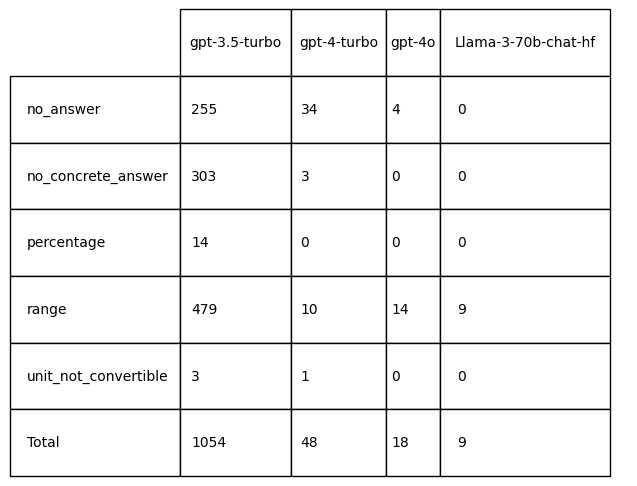

In [11]:
prompt_matrix = pd.crosstab(no_answer.comment, no_answer.model, margins=True, margins_name="Total")
prompt_matrix = prompt_matrix.reindex(columns=["gpt-3.5-turbo","gpt-4-turbo", "gpt-4o", "Llama-3-70b-chat-hf"])
#prompt_matrix = prompt_matrix.to_markdown()
#print(prompt_matrix)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Hide the axes
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
ax.set_frame_on(False)  # No frame

# Render the DataFrame as a table
tbl = ax.table(cellText=prompt_matrix.values, colLabels=prompt_matrix.columns, rowLabels=prompt_matrix.index, cellLoc='left', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.auto_set_column_width(col=list(range(len(prompt_matrix.columns))))
tbl.scale(1,4)

# Save the table as an image
#plt.savefig('Invalid answers matrix')

In [12]:
filtered_answers = answer_df[~answer_df.index.isin(no_answer.index)]

# total number of valid answers
len(filtered_answers)

54871

## Group values by experimental setting

Here, the answers are grouped by experimental setting and the statistics for each set of samples are calculated.

This includes both the original and the order of magnitude (OOM) format, even though the OOM format is primarily used for evaluation.

In [13]:
def mode_unique(val_group, description):
        mode = val_group.mode()[0] if len(val_group.mode()) == 1 else None
        description["mode"] = mode if mode else description["50%"]
        description["mode_count"] = val_group.value_counts().loc[mode] if mode else None
        description["unique"] = val_group.nunique()

        return description

def describe_convert(group, group_key, format, baseline_med = None):
    group_filtered = group.dropna(subset=[format])
    oom_data = group_filtered[format]
    oom_description = oom_data.describe().loc[['min', 'max', 'mean', '50%', 'std']].to_dict()
    oom_description = mode_unique(oom_data, oom_description)
    
    def create_description(description):
            description["target_id"] = group_key[0]
            description["model"] = group_key[1]
            description["context"] = group_key[2]
            description["context_bias"] = group_key[3]
            description["target_prompt"] = group_key[4]
            description["experiment_type"] = group_key[5]
            description["num_valid_answers"] = len(group)
      
            description["50%_difference"] = description["50%"] - baseline_med if baseline_med != None else 0

            return description

    oom_description = create_description(oom_description)

    return oom_description

Here, again a flag can be set to determine whether the stats should be recalculated. Otherwise, the data is loaded from the respective file.

In [14]:
redo_stats = False

if redo_stats:
    data_groups = filtered_answers.groupby(["target_id", "model", "context", "context_bias", "target_prompt", "experiment_type"])[["number", "order_of_magnitude"]]

    oom_data = []
    num_data = []

    skipped_items = []

    for model in filtered_answers["model"].unique():
        for target_question in filtered_answers["target_id"].unique():
            for target_prompt in filtered_answers["target_prompt"].unique():
                baseline_key = (target_question, model, "single_turn", "none", target_prompt, "neutral")
                skip = False
                try:
                    baseline = data_groups.get_group(baseline_key)
                except Exception as e:
                    skip = True
                    skipped_items.append(baseline_key)
                    
                
                target_groups = [[group_key, group] for group_key, group in data_groups if group_key[0] == target_question and group_key[1] == model and group_key[4] == target_prompt and group_key != baseline_key]
                
                if not skip:
                    baseline_oom = describe_convert(baseline, baseline_key, "order_of_magnitude")
                    oom_data.append(baseline_oom)
                    oom_med = baseline_oom["50%"]

                    baseline_num = describe_convert(baseline, baseline_key, "number")
                    num_data.append(baseline_num)
                    num_med = baseline_num["50%"]

                for group_key, val_group in target_groups:
                    group_oom = describe_convert(val_group, group_key, "order_of_magnitude", oom_med)
                    oom_data.append(group_oom)

                    group_num = describe_convert(val_group, group_key, "number", num_med)
                    num_data.append(group_num)


    oom_df = pd.DataFrame(oom_data)
    oom_df.to_pickle("saved_states/results_oom_df.pkl")

    num_df = pd.DataFrame(num_data)
    num_df.to_pickle("saved_states/results_num_df.pkl")
else:
    oom_df = pd.read_pickle("saved_states/results_oom_df.pkl")
    num_df = pd.read_pickle("saved_states/results_num_df.pkl")
    print(oom_df.shape)

(5593, 16)


## Evaluation and Result Analysis

In [15]:
# add function to create tables from a matrix
def show_table(tab_matrix, title):
    fig, ax = plt.subplots(figsize=(16, 4))
    
    ax.axis('off')

    if isinstance(tab_matrix.columns, pd.MultiIndex):
        tab_matrix.columns = [' '.join(col).strip() for col in tab_matrix.columns.values]

    tbl = table(ax, tab_matrix, loc='center', bbox=[0, 0, 1, 1])
    
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(12)
    plt.title(title)

    plt.show()

In [16]:
def convert_to_latex(matrix, caption, label):
    latex_code = matrix.to_latex(
        multicolumn=True,
        multirow=True,
        caption=caption,
        label=label,
        escape=False
    )

    return latex_code

### Accuracy

Compare LLM performances with different answer metrics.

In [17]:
# calculate the accuracy as defined in the reference paper by Kalyan et al.
def acc_score(target, answer):
    if answer == 0:
        return 0

    if abs(np.log10(target/answer)) > 3:
        return 0
    else:
        return 1 - (1/3 * abs(np.log10(target/answer)))

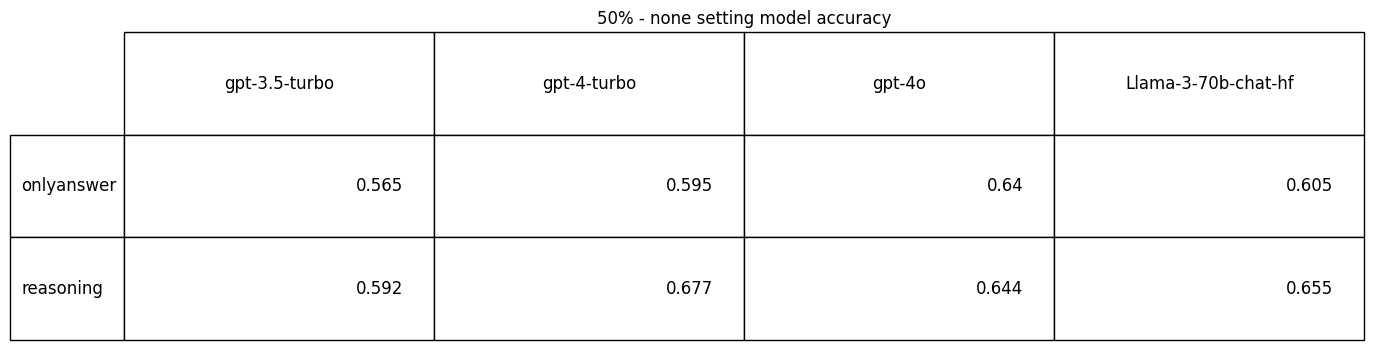

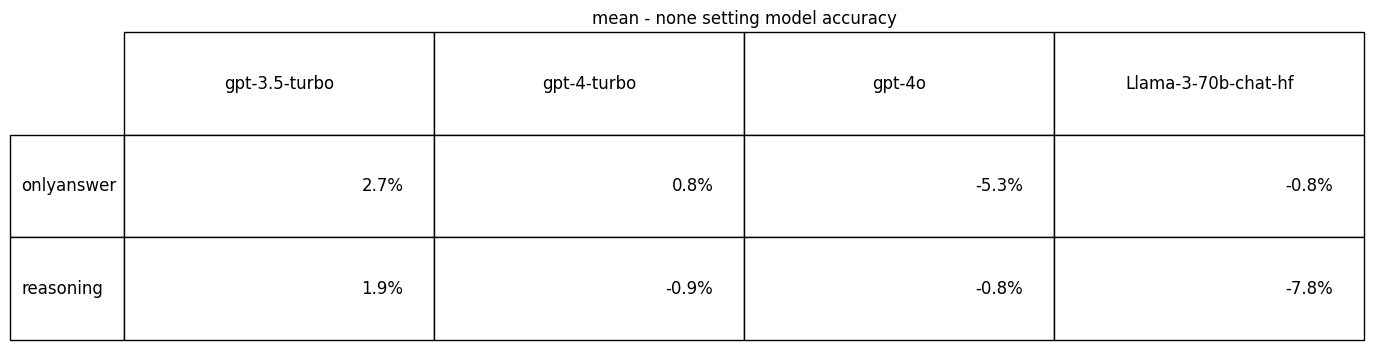

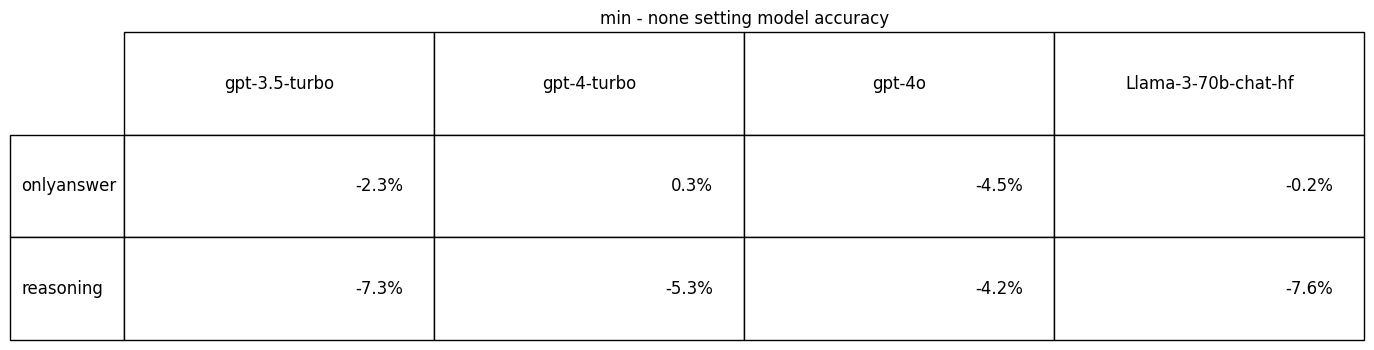

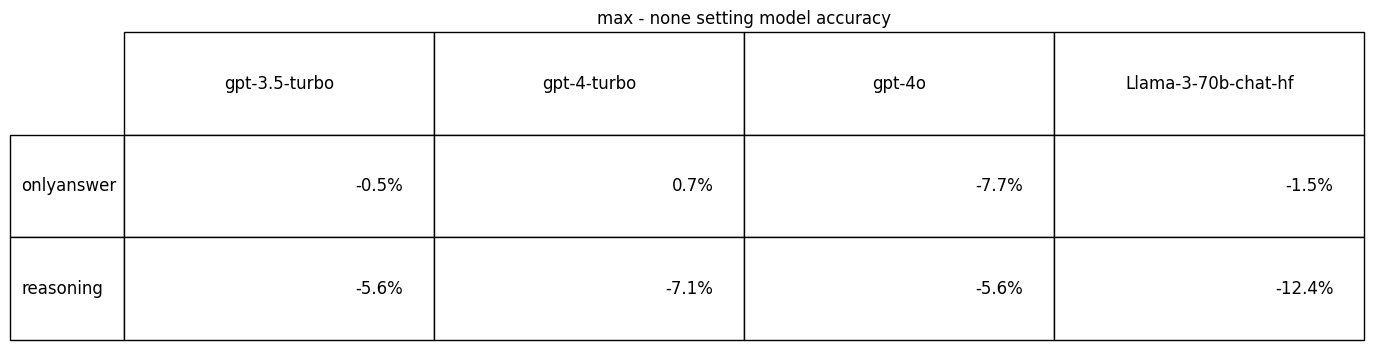

In [18]:
acc_scores = []
none_table = None
acc_metrics = ["50%", "mean", "min", "max"]

agreement = 0

for metric in acc_metrics:
    for bias in ["none"]:#, "control"]:
        for target_question in filtered_answers["target_id"].unique():
            for target_prompt in filtered_answers["target_prompt"].unique():
                for model in filtered_answers["model"].unique():
                    group_filter = (num_df["target_id"] == target_question) & (num_df["target_prompt"] == target_prompt) & (num_df["context_bias"] == bias) & (num_df["model"] == model)
                    model_data = num_df[group_filter]
                    target_answer = target_questions[target_questions["id"] == target_question]["answer"].iloc[0]
                    if len(model_data) == 1:
                        model_answer = model_data[metric].iloc[0]
                        acc = acc_score(target_answer, model_answer)
                        acc_scores.append(
                            {
                                "model": model,
                                "target_prompt": target_prompt,
                                "acc_score": acc
                            }
                        )


        df = pd.DataFrame(acc_scores)

        matrix = np.round(df.pivot_table(index='target_prompt', columns='model', values='acc_score', aggfunc='mean'), 3)
        if bias == "none" and metric == "50%":
            none_table = matrix
        else:
            matrix = np.round((matrix - none_table) / none_table * 100, 1).astype(str) + '%'

        matrix = matrix.reindex(columns=["gpt-3.5-turbo","gpt-4-turbo", "gpt-4o", "Llama-3-70b-chat-hf"])

        title = "{} - {} setting model accuracy".format(metric, bias)
        show_table(matrix, title)


### Model Stability

Compare the average standard deviations and unique OOMs per experimental setting and FP

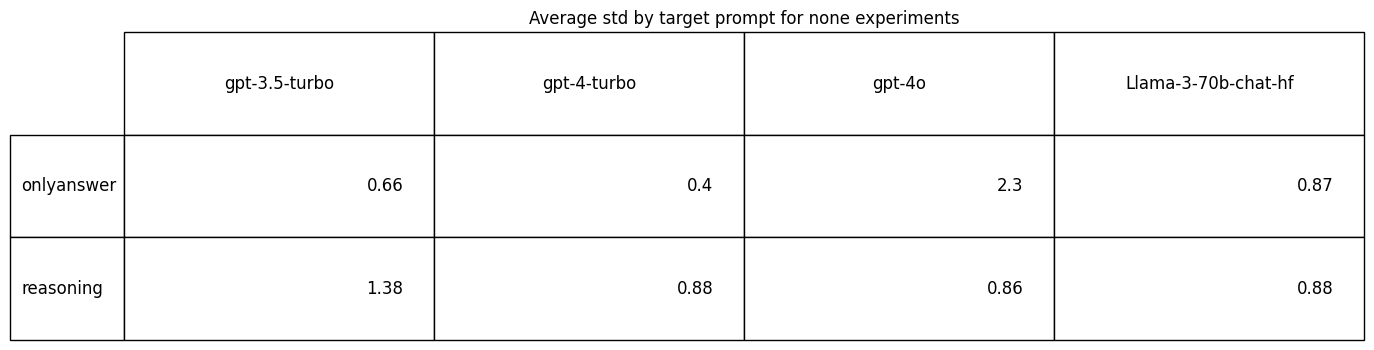

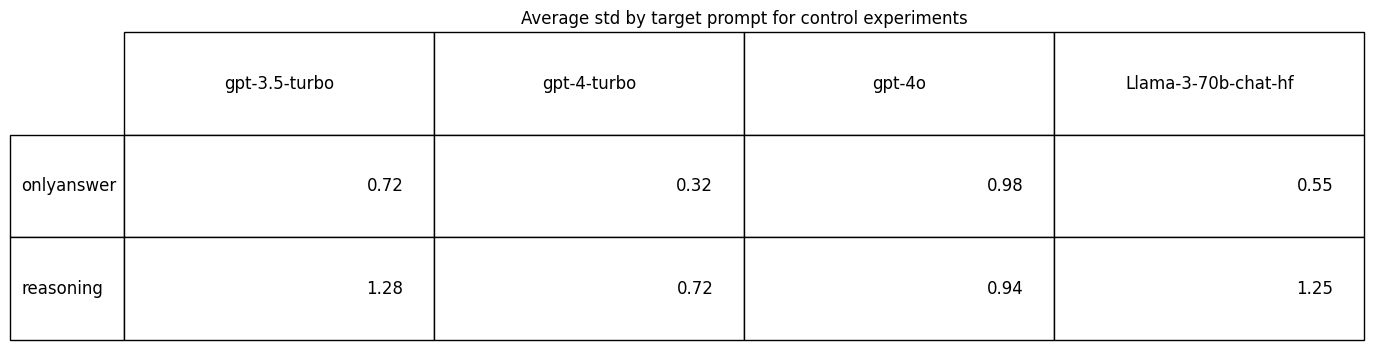

In [19]:
std_data = oom_df[oom_df["std"] != np.inf].groupby(["model",  "context_bias", "target_prompt"])# , "experiment_type"])
biases = ["none", "control"]

def std_table(target_metric):
    for bias in biases:
        table_data = []
        for key, val_group in std_data:
        
            for model in filtered_answers["model"].unique():
                if key[0] == model and key[1] == bias:
                    std = val_group[target_metric].describe().loc["mean"]
                    max_data = val_group.loc[val_group[target_metric].idxmax()][["target_id", "model", "target_prompt", "context_bias", "experiment_type", "std"]].to_dict()
                    item = {
                        "model": key[0],
                        "target_prompt": key[2],
                        "std": std.round(2)
                    }
                    table_data.append(item)


        # Convert data to DataFrame
        df = pd.DataFrame(table_data)

        matrix = df.pivot_table(index='target_prompt', columns='model', values="std")
        matrix = matrix.reindex(columns=["gpt-3.5-turbo","gpt-4-turbo", "gpt-4o", "Llama-3-70b-chat-hf"])

        if len(biases) > 2:
            average_row = matrix.mean(axis=0).round(3).to_frame().T
            average_row.index = ['Average']

            # Append the average row to the pivot table
            matrix = pd.concat([matrix, average_row])

        title = "Average {} by target prompt for {} experiments".format(target_metric.replace("_", " "), bias)
        show_table(matrix, title)

target_metric = "std"
std_table(target_metric)

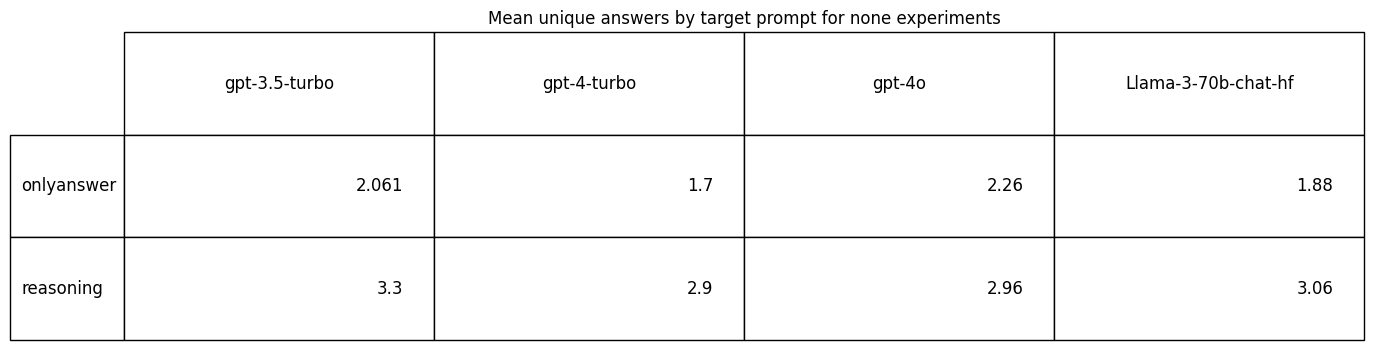

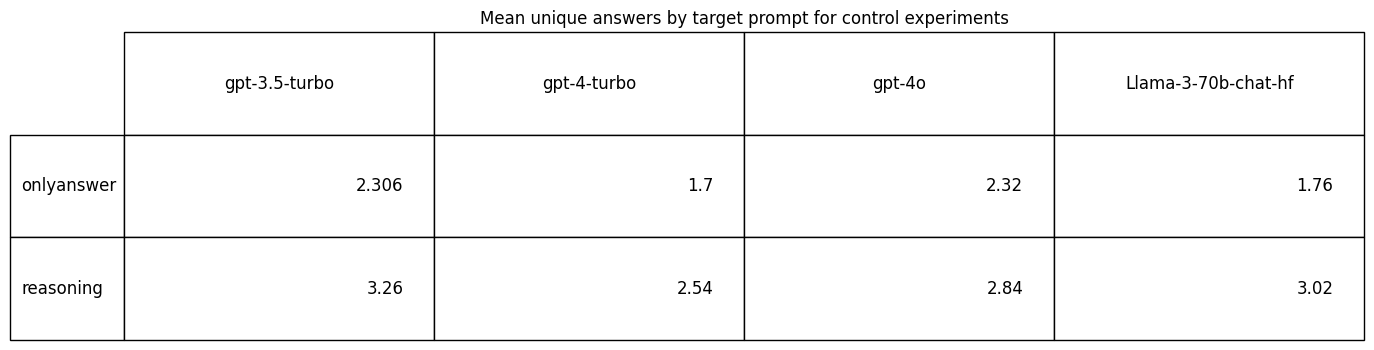

In [20]:
ua_data = oom_df[oom_df["unique"] != np.inf].groupby(["model",  "context_bias", "target_prompt"])# , "experiment_type"])
ua_biases = ["none", "control"]


def ua_table(target_metric):
    for bias in ua_biases:
        table_data = []
        for key, val_group in ua_data:
            for model in filtered_answers["model"].unique():
                if key[0] == model and key[1] == bias:
                    ua = val_group[target_metric].describe().loc["mean"]
                    item = {
                        "model": key[0],
                        "target_prompt": key[2],
                        "ua": ua.round(3)
                    }
                    table_data.append(item)


        # Convert data to DataFrame
        df = pd.DataFrame(table_data)

        matrix = df.pivot_table(index='target_prompt', columns='model', values="ua")
        matrix = matrix.reindex(columns=["gpt-3.5-turbo","gpt-4-turbo", "gpt-4o", "Llama-3-70b-chat-hf"])

        if len(ua_biases) > 2:
            average_row = matrix.mean(axis=0).round(3).to_frame().T
            average_row.index = ['Average']

            matrix = pd.concat([matrix, average_row])

        title = "Mean unique answers by target prompt for {} experiments".format(bias)
        show_table(matrix, title)

target_metric = "unique"
ua_table(target_metric)

### Control setting impact

{'target_id': 27, 'model': 'gpt-3.5-turbo', 'target_prompt': 'onlyanswer', 'context_bias': 'control'}
gpt-3.5-turbo onlyanswer 0.5714285714285714
{'target_id': 27, 'model': 'gpt-4-turbo', 'target_prompt': 'onlyanswer', 'context_bias': 'control'}
gpt-4-turbo onlyanswer 0.8181818181818182
{'target_id': 35, 'model': 'gpt-4o', 'target_prompt': 'onlyanswer', 'context_bias': 'control'}
gpt-4o onlyanswer 0.35294117647058826
{'target_id': 23, 'model': 'Llama-3-70b-chat-hf', 'target_prompt': 'onlyanswer', 'context_bias': 'control'}
Llama-3-70b-chat-hf onlyanswer 0.5555555555555556
{'target_id': 46, 'model': 'gpt-3.5-turbo', 'target_prompt': 'reasoning', 'context_bias': 'control'}
gpt-3.5-turbo reasoning 0.6923076923076923
{'target_id': 18, 'model': 'gpt-4-turbo', 'target_prompt': 'reasoning', 'context_bias': 'control'}
gpt-4-turbo reasoning 0.5
{'target_id': 35, 'model': 'gpt-4o', 'target_prompt': 'reasoning', 'context_bias': 'control'}
gpt-4o reasoning 0.4166666666666667
{'target_id': 35, 'mod

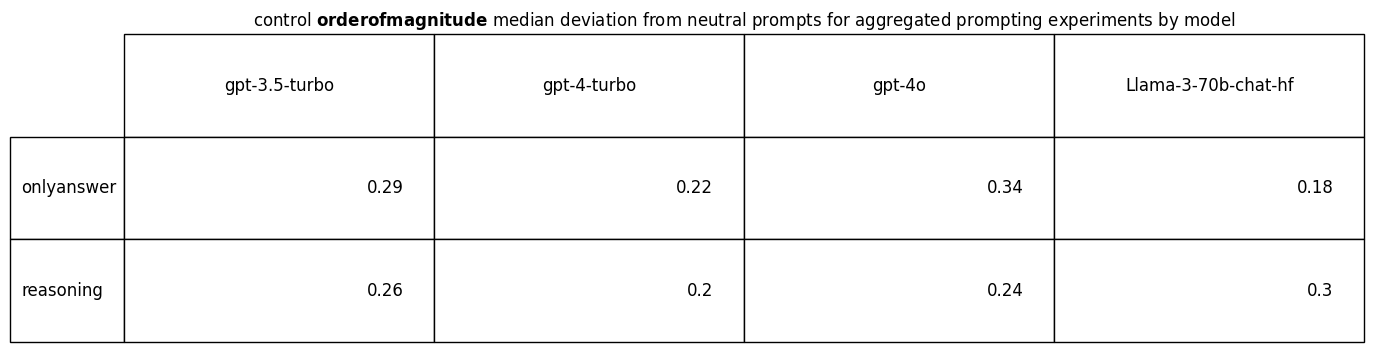

In [21]:
control_target_metric = "50%_difference"

data_sources = {
    "order of magnitude": oom_df
}


def control_print(bias):
    for data_label, control_df in data_sources.items():
        control_table_data = []
        analysis_data = control_df.groupby(["model", "target_prompt", "context_bias", "experiment_type"])
        for target_prompt in filtered_answers["target_prompt"].unique():
            for model in filtered_answers["model"].unique():
                for key, val_group in analysis_data:
                    if key[0] == model and key[1] == target_prompt and key[2] == bias:
                        print(val_group.loc[val_group[control_target_metric].abs().idxmax()][["target_id", "model", "target_prompt", "context_bias"]].to_dict())


                        above_zero = (val_group[control_target_metric] > 0.5).sum()
                        equal_to_zero = ((val_group[control_target_metric] <= 0.5) & (val_group[control_target_metric] >= -0.5)).sum()
                        below_zero = (val_group[control_target_metric] < -0.5).sum()

                        val = round((above_zero + below_zero) / (above_zero + equal_to_zero + below_zero), 2)

                        inc_ratio = above_zero / (above_zero + below_zero)

                        item = {
                            "model": key[0],
                            "target_prompt": key[1],
                            "context_bias": key[2],
                            "value": val,
                        }
                        control_table_data.append(item)

                        print(model, target_prompt, inc_ratio)

        df = pd.DataFrame(control_table_data)
        matrix = df.pivot(index='target_prompt', columns='model', values="value")
        matrix = matrix.reindex(columns=["gpt-3.5-turbo","gpt-4-turbo", "gpt-4o", "Llama-3-70b-chat-hf"])
        title = bias + " " + r"$\bf{" + data_label + "}$"+ " median deviation from neutral prompts for aggregated prompting experiments by model"
        show_table(matrix, title)

control_print("control")

### rSSG analysis

In [22]:
def get_question_classification(val):
    if val < 0:
        return -1
    elif val < 0:
        return 1
    else:
        return 0

# classify questions into the categories "expected", "reversed" and "neutral"
def collect_question_classifications(df_down, df_up, df_control, col, bias, target_prompt, qids = False):
    same = 0
    exp = 0
    rev = 0
    baseline_ok = 0

    total_rows = 0

    results = []

    question_ids = {
        "exp": [],
        "rev": [],
        "neutral": []
    }

    for model in df_down["model"].unique():
        for target_prompt in df_down["target_prompt"].unique():
            for target_id in df_down["target_id"].unique():
                try:
                    dec = df_down[(df_down["target_id"] == target_id) & (df_down["model"] == model) & (df_down["target_prompt"] == target_prompt)][col].iloc[0]
                    inc = df_up[(df_up["target_id"] == target_id) & (df_up["model"] == model)& (df_up["target_prompt"] == target_prompt)][col].iloc[0]
                    
                    if math.isnan(dec) or math.isnan(inc):
                        pass
                    else:    
                        if abs(dec-inc) <= 0.5:
                            same += 1
                            if abs(dec) < 1 and abs(inc) < 1:
                                question_ids["neutral"].append(target_id)
                                baseline_ok += 1
                        else:
                            if dec < inc:
                                exp += 1
                                question_ids["exp"].append(target_id)
 
                            elif inc < dec:
                                rev += 1
                                question_ids["rev"].append(target_id)
                            
                        total_rows += 1
                    
                except Exception as e:
                    print(e, model, target_id, target_prompt)

    results.append({
        "id": df_down["model"].unique()[0]  + "/" + target_prompt,
        "context_bias": bias,
        "target_prompt": target_prompt,
        "class": "neutral",
        "share": f"{same/total_rows:.1%}"
    })
    results.append({
        "id": df_down["model"].unique()[0]  + "/" + target_prompt,
        "context_bias": bias,
        "target_prompt": target_prompt,
        "class": "neutral_baseline",
        "share": baseline_ok/same
    })
    results.append({
        "id": df_down["model"].unique()[0]  + "/" + target_prompt,
        "context_bias": bias,
        "target_prompt": target_prompt,
        "class": "changed",
        "share": round((exp+rev)/total_rows,2)
    })
    results.append({
        "id": df_down["model"].unique()[0]  + "/" + target_prompt,
        "context_bias": bias,
        "target_prompt": target_prompt,
        "class": "expected_share",
        "share": round((exp)/(exp+rev),2)
    })

    if qids:
        return question_ids
    else:
        return results
    

single positional indexer is out-of-bounds gpt-3.5-turbo 49 onlyanswer
single positional indexer is out-of-bounds gpt-3.5-turbo 40 onlyanswer
context_bias
general                   0.5925
question_anchor          0.67875
answer_anchor            0.65875
implicit_confirmation     0.6325
explicit_confirmation      0.555
availability              0.5325
dtype: object
0.6083333333333333
id
Llama-3-70b-chat-hf/onlyanswer       0.625
Llama-3-70b-chat-hf/reasoning         0.59
gpt-3.5-turbo/onlyanswer              0.68
gpt-3.5-turbo/reasoning           0.656667
gpt-4-turbo/onlyanswer            0.553333
gpt-4-turbo/reasoning                 0.63
gpt-4o/onlyanswer                 0.643333
gpt-4o/reasoning                  0.488333
dtype: object
0.6083333333333333


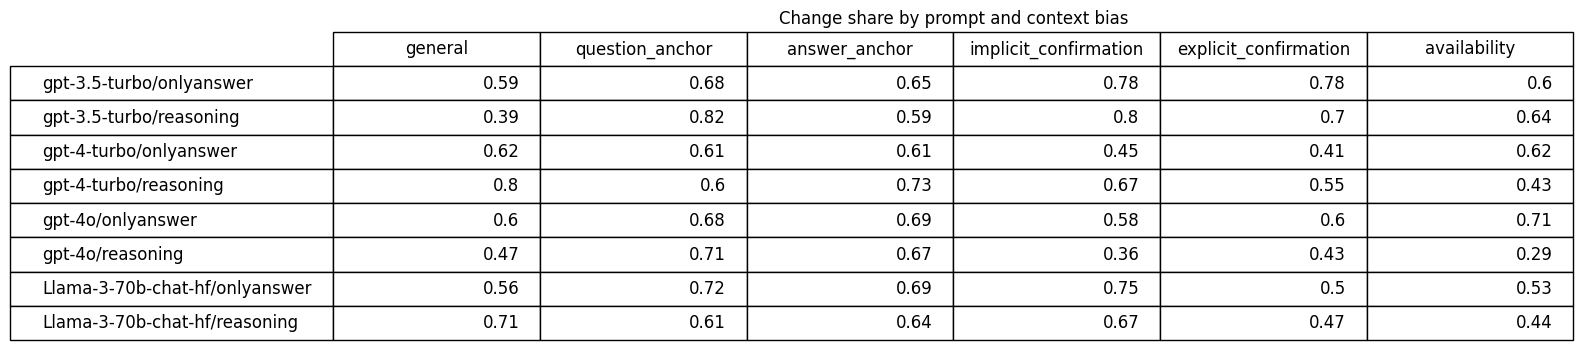

In [23]:
ratio_metric = "50%_difference"

ratio_data = oom_df.groupby(["model", "target_prompt", "context_bias", "experiment_type"]) #"target_prompt",

ratios = []

for model in oom_df["model"].unique():
    for target_prompt in oom_df["target_prompt"].unique():
        control_key = (model, target_prompt, "control", "neutral")
        control = ratio_data.get_group(control_key)
        for bias in oom_df["context_bias"].unique():
            if bias not in ["control", "none"]:
                dec_key = (model, target_prompt, bias, "decrease")
                dec = ratio_data.get_group(dec_key)
                inc_key = (model, target_prompt, bias, "increase")
                inc = ratio_data.get_group(inc_key)
                ratios += (collect_question_classifications(dec, inc, control, ratio_metric, bias, "both"))
            
ratios = pd.DataFrame(ratios)
ratios = ratios[ratios["class"] == "expected_share"]
matrix = ratios.pivot(index='id', columns='context_bias', values='share')
matrix = matrix.reindex(["general", "question_anchor", "answer_anchor", "implicit_confirmation", "explicit_confirmation", "availability"], axis=1)

column_means = matrix.mean(axis=0)
row_means = matrix.mean(axis=1)

print(column_means)
print(column_means.mean())
print(row_means)
print(row_means.mean())

matrix = matrix.reindex(["gpt-3.5-turbo/onlyanswer", "gpt-3.5-turbo/reasoning", "gpt-4-turbo/onlyanswer", "gpt-4-turbo/reasoning", "gpt-4o/onlyanswer", "gpt-4o/reasoning", "Llama-3-70b-chat-hf/onlyanswer", "Llama-3-70b-chat-hf/reasoning"])
title = "Change share by prompt and context bias"
show_table(matrix, title)

Print most consistently and least consistenly answered questions. This is defined by the amount of experiments across all models and target prompts, that ins answered within a median range of 0.5 with the baseline, increase and decrease experiment type (and their distribution among models and biases).

In [24]:
q_metric = "50%_difference"

q_data = oom_df.groupby(["model", "target_prompt", "context_bias", "experiment_type"]) #"target_prompt",

qs = {}

for model in oom_df["model"].unique():
    for target_prompt in oom_df["target_prompt"].unique():
        control_key = (model, target_prompt, "control", "neutral")
        control = q_data.get_group(control_key)
        for bias in oom_df["context_bias"].unique():
            if bias not in ["control", "none"]:
                dec_key = (model, target_prompt, bias, "decrease")
                dec = q_data.get_group(dec_key)
                inc_key = (model, target_prompt, bias, "increase")
                inc = q_data.get_group(inc_key)
                qs[(model, target_prompt, bias)] = collect_question_classifications(dec, inc, control, q_metric, bias, "both", qids=True)

from collections import defaultdict, Counter         
def count_question_ids(qs):
    exp_counter = defaultdict(lambda: defaultdict(Counter))
    rev_counter = defaultdict(lambda: defaultdict(Counter))
    neutral_counter = defaultdict(lambda: defaultdict(Counter))
    
    for (model, target_prompt, bias), data in qs.items():
        for qid in data["neutral"]:
            neutral_counter["model"][model][qid] += 1
            neutral_counter["target_prompt"][target_prompt][qid] += 1
            neutral_counter["context_bias"][bias][qid] += 1
            neutral_counter["total"]["total"][qid] += 1
          
    return neutral_counter

# Count the question IDs
neutral_counter = count_question_ids(qs)

def top_common_questions(counter, top_n=5, reverse=False):
    top_common = {}
    for dim, groups in counter.items():
        top_common[dim] = {}
        for group, counts in groups.items():
            if top_n is not None:
                if reverse:
                    vals = counts.most_common()[-top_n:]
                else:
                    vals = counts.most_common(top_n)
                top_common[dim][group] = dict(vals)
            else:
                top_common[dim][group] = dict(counts.items())
    return top_common

# Find the top 5 most common question IDs for each dimension
top_common_neutral = top_common_questions(neutral_counter, 10)
least_common_neutral = top_common_questions(neutral_counter, 10, reverse=True)

print("\nTop 5 most consistently answered questions by dimension and group:")
for dim, groups in top_common_neutral.items():
    if dim == "total":
        print(f"Dimension: {dim}")
        for group, top_questions in groups.items():
            print(f"  Group: {group}")
            for qid, count in top_questions.items():
                print(f"    Question ID {qid} with {count} occurrences")
                print("    {}".format(target_questions[target_questions["id"] == qid].iloc[0]["question"]))
                s1 = top_common_questions(neutral_counter, None)["target_prompt"]["onlyanswer"].get(qid, 0)
                s2 = top_common_questions(neutral_counter, None)["target_prompt"]["reasoning"].get(qid, 0)
                print(f"    onlyanswer: {s1} / reasoning: {s2}")
                m1 = top_common_questions(neutral_counter, None)["model"]["gpt-3.5-turbo"].get(qid, 0)
                m2 = top_common_questions(neutral_counter, None)["model"]["gpt-4-turbo"].get(qid, 0)
                m3 = top_common_questions(neutral_counter, None)["model"]["gpt-4o"].get(qid, 0)
                m4 = top_common_questions(neutral_counter, None)["model"]["Llama-3-70b-chat-hf"].get(qid, 0)
                print(f"    gpt-3.5-turbo: {m1} / gpt-4-turbo: {m2} / gpt-4o: {m3} / Llama-3: {m4}")
                c1 = top_common_questions(neutral_counter, None)["context_bias"]["general"].get(qid, 0)
                c2 = top_common_questions(neutral_counter, None)["context_bias"]["question_anchor"].get(qid, 0)
                c3 = top_common_questions(neutral_counter, None)["context_bias"]["answer_anchor"].get(qid, 0)
                c4 = top_common_questions(neutral_counter, None)["context_bias"]["implicit_confirmation"].get(qid, 0)
                c5 = top_common_questions(neutral_counter, None)["context_bias"]["explicit_confirmation"].get(qid, 0)
                c6 = top_common_questions(neutral_counter, None)["context_bias"]["availability"].get(qid, 0)
                print(f"    general: {c1} / question_anchor: {c2} / answer_anchor: {c3} / implicit_confirmation: {c4} / explicit_confirmation: {c5} / availability: {c6}\n")

print("\n\nTop 5 least consistently answered questions by dimension and group:")
for dim, groups in least_common_neutral.items():
    if dim == "total":
        print(f"Dimension: {dim}")
        for group, top_questions in groups.items():
            print(f"  Group: {group}")
            for qid, count in top_questions.items():
                print(f"    Question ID {qid} with {count} occurrences")
                print("    {}".format(target_questions[target_questions["id"] == qid].iloc[0]["question"]))
                s1 = top_common_questions(neutral_counter, None)["target_prompt"]["onlyanswer"].get(qid, 0)
                s2 = top_common_questions(neutral_counter, None)["target_prompt"]["reasoning"].get(qid, 0)
                print(f"    onlyanswer: {s1} / reasoning: {s2}")
                m1 = top_common_questions(neutral_counter, None)["model"]["gpt-3.5-turbo"].get(qid, 0)
                m2 = top_common_questions(neutral_counter, None)["model"]["gpt-4-turbo"].get(qid, 0)
                m3 = top_common_questions(neutral_counter, None)["model"]["gpt-4o"].get(qid, 0)
                m4 = top_common_questions(neutral_counter, None)["model"]["Llama-3-70b-chat-hf"].get(qid, 0)
                print(f"    gpt-3.5-turbo: {m1} / gpt-4-turbo: {m2} / gpt-4o: {m3} / Llama-3: {m4}")
                c1 = top_common_questions(neutral_counter, None)["context_bias"]["general"].get(qid, 0)
                c2 = top_common_questions(neutral_counter, None)["context_bias"]["question_anchor"].get(qid, 0)
                c3 = top_common_questions(neutral_counter, None)["context_bias"]["answer_anchor"].get(qid, 0)
                c4 = top_common_questions(neutral_counter, None)["context_bias"]["implicit_confirmation"].get(qid, 0)
                c5 = top_common_questions(neutral_counter, None)["context_bias"]["explicit_confirmation"].get(qid, 0)
                c6 = top_common_questions(neutral_counter, None)["context_bias"]["availability"].get(qid, 0)
                print(f"    general: {c1} / question_anchor: {c2} / answer_anchor: {c3} / implicit_confirmation: {c4} / explicit_confirmation: {c5} / availability: {c6}\n")

single positional indexer is out-of-bounds gpt-3.5-turbo 49 onlyanswer
single positional indexer is out-of-bounds gpt-3.5-turbo 40 onlyanswer

Top 5 most consistently answered questions by dimension and group:
Dimension: total
  Group: total
    Question ID 6 with 48 occurrences
    How many illiterate people are there in India?
    onlyanswer: 24 / reasoning: 24
    gpt-3.5-turbo: 12 / gpt-4-turbo: 12 / gpt-4o: 12 / Llama-3: 12
    general: 8 / question_anchor: 8 / answer_anchor: 8 / implicit_confirmation: 8 / explicit_confirmation: 8 / availability: 8

    Question ID 25 with 48 occurrences
    How long does a person sleep in a lifetime?
    onlyanswer: 24 / reasoning: 24
    gpt-3.5-turbo: 12 / gpt-4-turbo: 12 / gpt-4o: 12 / Llama-3: 12
    general: 8 / question_anchor: 8 / answer_anchor: 8 / implicit_confirmation: 8 / explicit_confirmation: 8 / availability: 8

    Question ID 15 with 46 occurrences
    How many pizzas were eaten last year in the U.S.?
    onlyanswer: 24 / reasonin

### High Baseline Persistence (HBP)

Determine the quality of HBP as a predictor for stable output

Recalculate the rSSG values for experiments with high baseline persistence (mode count >= 8), as well as total SGs

In [25]:
# print distribution between high and low baseline persistence experiments
conf_df = oom_df.groupby(["model", "target_prompt", "context_bias"])
target_metric = "mode_count"

confs = {}

for model in oom_df["model"].unique():
    for target_prompt in oom_df["target_prompt"].unique():
        conf_cat = {
            "small": [],
            "large": []
        }

        key = (model, target_prompt, "none")
        val_group = conf_df.get_group(key)
        for _, (id, val) in val_group[["target_id", target_metric]].iterrows():
            if val >= 8:
                conf_cat["large"].append(id)
            else:
                conf_cat["small"].append(id)

        confs[(model, target_prompt)] = conf_cat

        print(model, target_prompt, len(conf_cat["large"]), len(conf_cat["small"]))

gpt-3.5-turbo onlyanswer 28 21
gpt-3.5-turbo reasoning 13 37
gpt-4-turbo onlyanswer 35 15
gpt-4-turbo reasoning 20 30
gpt-4o onlyanswer 28 22
gpt-4o reasoning 17 33
Llama-3-70b-chat-hf onlyanswer 31 19
Llama-3-70b-chat-hf reasoning 14 36


gpt-3.5-turbo onlyanswer 53 43
total 0.5348837209302325 23 43
CONTROL 0.6666666666666666 6 [1.0, 12.0, 16.0, 17.0, 34.0, 40.0] {(16, 'explicit_confirmation'), (17, 'general'), (12, 'general'), (16, 'question_anchor'), (1, 'explicit_confirmation'), (17, 'implicit_confirmation'), (12, 'availability'), (1, 'question_anchor'), (16, 'answer_anchor'), (12, 'answer_anchor')}
gpt-3.5-turbo reasoning 5 5
CONTROL NO EXCEPTIONS
gpt-4-turbo onlyanswer 75 54
total 0.5740740740740741 31 54
CONTROL 1.0 4 [10.0, 24.0, 41.0, 48.0] {(13, 'explicit_confirmation'), (13, 'general'), (5, 'question_anchor'), (13, 'availability'), (24, 'availability'), (22, 'implicit_confirmation'), (41, 'explicit_confirmation'), (41, 'general'), (10, 'general'), (8, 'explicit_confirmation'), (18, 'question_anchor'), (24, 'implicit_confirmation'), (8, 'availability'), (41, 'availability'), (41, 'answer_anchor'), (10, 'answer_anchor'), (34, 'general'), (11, 'question_anchor'), (48, 'question_anchor'), (41, 'implicit_confirmati

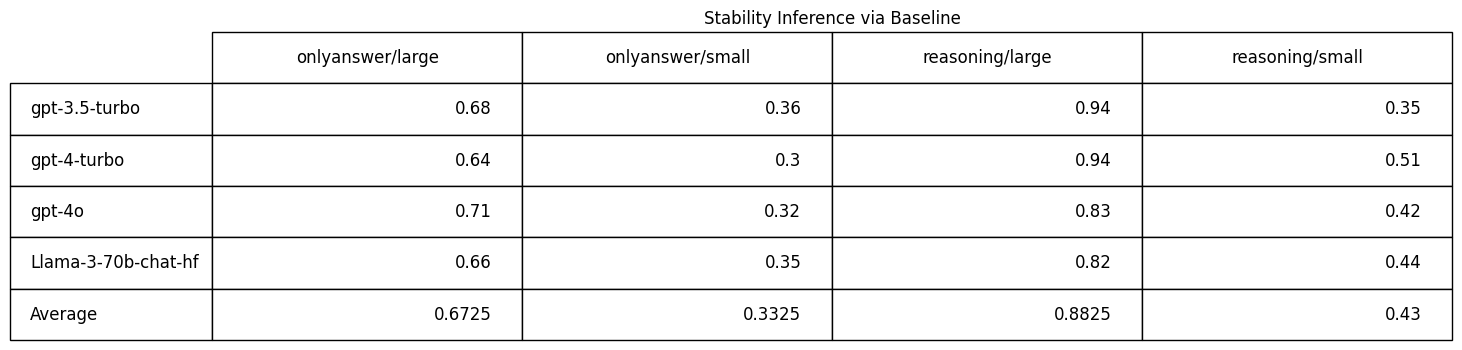

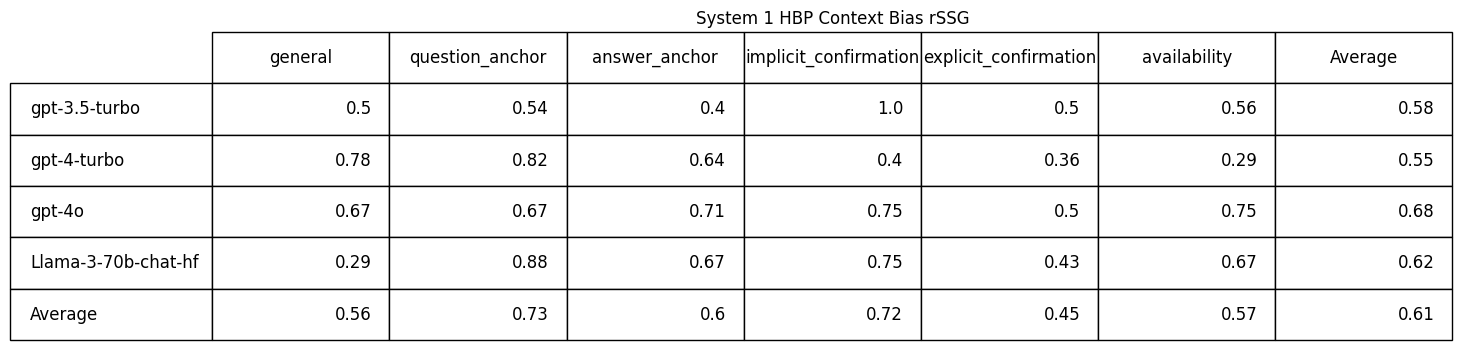

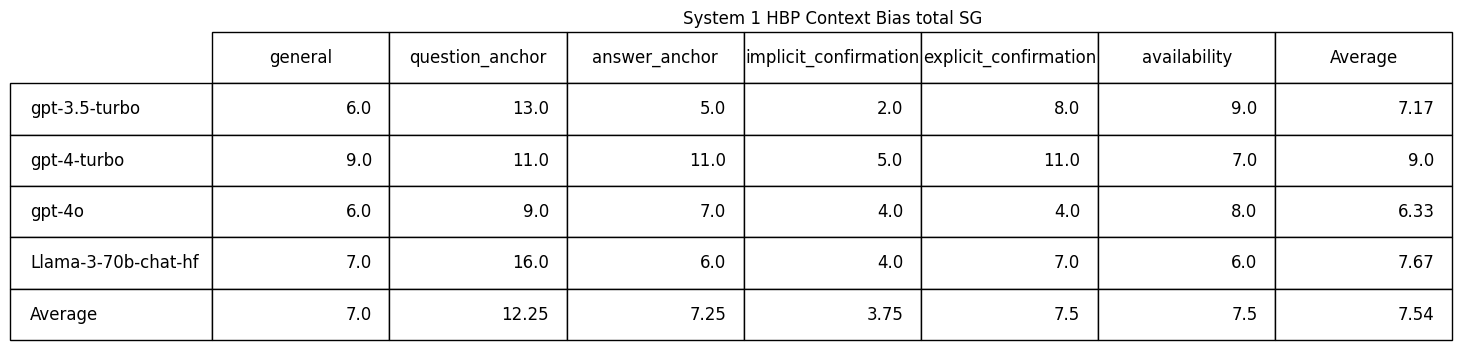

In [26]:
inf_df = oom_df.groupby(["model", "target_prompt", "context_bias", "experiment_type", "target_id"])

s1_exp_ooms = []

baseline_inf = []
for (model, target_prompt), conf_cat in confs.items():
    for b_conf, qids in conf_cat.items():
        change = 0
        no_change = 0
        mode_count = 0

        control_exc = []
        exc = []
        same = []
        exc_s1 = 0
        exp = 0
        rev = 0

        s1_biases = {}

        oom_num_equivalence = 0

        for qid in qids:
            for context_bias in oom_df["context_bias"].unique():
                if context_bias not in ["none", "control"]:
                    try:
                        dec_key = (model, target_prompt, context_bias, "decrease", int(qid))
                        inc_key = (model, target_prompt, context_bias, "increase", int(qid))

                        dec = inf_df.get_group(dec_key).iloc[0]["50%_difference"]
                        inc = inf_df.get_group(inc_key).iloc[0]["50%_difference"]


                        if abs(inc-dec) < 1 and abs(inc) < 1 and abs(dec) < 1:
                            no_change += 1
                            dec_mode = inf_df.get_group(dec_key).iloc[0]["mode_count"]
                            inc_mode = inf_df.get_group(inc_key).iloc[0]["mode_count"]
                            mode_count += 0 if math.isnan(dec_mode) else dec_mode
                            mode_count += 0 if math.isnan(inc_mode) else inc_mode
                        else:
                            change += 1

                            if context_bias not in s1_biases.keys():
                                s1_biases[context_bias] = {
                                    "exp": 0,
                                    "rev": 0,
                                    "same": 0
                                }

                            if inc > dec and abs(inc-dec) > 0.5:
                                exp +=1
                                s1_biases[context_bias]["exp"] += 1
                            if dec > inc and abs(inc-dec) > 0.5:
                                rev += 1
                                s1_biases[context_bias]["rev"] += 1
                            if abs(inc-dec) < 1:
                                s1_biases[context_bias]["same"] += 1
                                same.append((int(qid),context_bias))

                            exc.append((int(qid),context_bias))

                            if target_prompt == "reasoning" and b_conf == "large":
                                

                                if qid in confs[(model, "onlyanswer")]["large"]:
                                    dec_key = (model, "onlyanswer", context_bias, "decrease", int(qid))
                                    inc_key = (model, "onlyanswer", context_bias, "increase", int(qid))
            
                                    dec = inf_df.get_group(dec_key).iloc[0]["50%_difference"]
                                    inc = inf_df.get_group(inc_key).iloc[0]["50%_difference"]

                                    if not(abs(inc-dec) < 1 and abs(inc) < 1 and abs(dec) < 1):
                                        exc_s1 += 1
                    except:
                        pass

                elif context_bias == "control" and b_conf == "large":
                    try:
                        control_key = (model, target_prompt, context_bias, "neutral", int(qid))
                        control = inf_df.get_group(control_key).iloc[0]["50%_difference"]
                        if abs(control) > 0.5:
                            control_exc.append(qid)
                    except:
                        pass
        
        baseline_inf.append({
            "model": model,
            "target_prompt": target_prompt,
            "confidence": b_conf,
            "col": target_prompt + "/" + b_conf,
            "vals": round(no_change/(change+no_change), 2),
            "mode": round(mode_count/(no_change * 2), 2)
        })

    print(model, target_prompt, len(exc), len(set(exc) - set(same)))
    if target_prompt == "onlyanswer":
        exp = 0
        total = 0
        for bias, res in s1_biases.items():
            s1_exp_ooms.append({
                "model": model,
                "context_bias": bias,
                "ratio": round(res["exp"]/(res["exp"]+res["rev"]), 2) if res["exp"] > 0 else 0,
                "total": (res["exp"]+res["rev"])
            })
            exp += res["exp"]
            total += res["exp"]+res["rev"]
        print("total", exp/total, exp, total)

    common_fps = [el[0] for el in exc]
    if len(control_exc) > 0:
        print("CONTROL", len([el for el in control_exc if el in [x[0] for x in same]])/len(control_exc), len(control_exc), control_exc, set(same))
    else:
        print("CONTROL NO EXCEPTIONS")

inf_results = pd.DataFrame(baseline_inf)


matrix = inf_results.pivot(index='model', columns='col', values='vals')
matrix.loc['Average'] = matrix.mean(axis=0)

matrix = matrix.reindex(["gpt-3.5-turbo","gpt-4-turbo", "gpt-4o", "Llama-3-70b-chat-hf", "Average"])

title = "Stability Inference via Baseline"
show_table(matrix, title)

s1_exp_ratios = pd.DataFrame(s1_exp_ooms)
matrix = s1_exp_ratios.pivot(index='model', columns='context_bias', values='ratio')
matrix['Average'] = matrix.mean(axis=1).round(2)
matrix.loc['Average'] = round(matrix.mean(axis=0), 2)

matrix = matrix.reindex(["gpt-3.5-turbo","gpt-4-turbo", "gpt-4o", "Llama-3-70b-chat-hf", "Average"])
matrix = matrix.reindex(["general", "question_anchor", "answer_anchor", "implicit_confirmation", "explicit_confirmation", "availability", "Average"], axis=1)

title = "System 1 HBP Context Bias rSSG"
show_table(matrix, title)

matrix = s1_exp_ratios.pivot(index='model', columns='context_bias', values='total')
matrix['Average'] = matrix.mean(axis=1).round(2)
matrix.loc['Average'] = round(matrix.mean(axis=0), 2)

matrix = matrix.reindex(["gpt-3.5-turbo","gpt-4-turbo", "gpt-4o", "Llama-3-70b-chat-hf", "Average"])
matrix = matrix.reindex(["general", "question_anchor", "answer_anchor", "implicit_confirmation", "explicit_confirmation", "availability", "Average"], axis=1)

title = "System 1 HBP Context Bias total SG"
show_table(matrix, title)